# Characteristics of Countries that correlate with use of nuclear energy

This notebook will be used to document the exploration of the question:

_"Are there characteristics of a country that correlate with increases or decreases in
the use of nuclear energy?"_

In order to gather information about this topic, we are going to use the "World Values Survey" (WVS).
It is a dataset that records various psychological effects and phenomena of citizen from various countries.
The data in the WVS is collected from the World Value Study and the European Value Study. Hence, some
questions/features included in the dataset are not available for certain countries.
Data is collected in 5-Year intervals. This is important to know, as merging the data on years with other
datasets will require some tweaking of the granularity of the time data (5-year versus 1-year etc.).

For the nuclear energy part, we are going to rely on the "Our World in Data - Energy" (OWID) dataset. We
also use this dataset for a few other questions we try to answer. It contains yearly information about
various energy features, including nuclear, renewable, coal and many more. We are going to focus solely
on the nuclear energy related features to research this question.

## Loading the data
As first step, we will import all the python packages we are going to use later on.
We also import the datasets from .sav and .csv respectively. The .sav file is generated
using IBM's SPSS software according to the WVS guide.

In [1]:
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df, meta = pyreadstat.read_sav("data/VWS/Integrated_values_surveys_1981-2021.sav", encoding="cp850")

In [31]:
owid = pd.read_csv("data/OWID_energy/owid-energy-data.csv")

### Pre-Processing for WVS

As first step, we convert the year column from float to integer.

We then collect the data from 1980 and 1985 into one interval, as there
are very few values recorded in 1985 (See exploration notebook).

In [12]:
df["year"] = (df["S020"].astype(int)//5 * 5)
df.loc[df["year"] == 1985, "year"] = 1980

We can see that amount of data recorded between the years varies greatly.
This may impact our analysis going forward if we use years with low number of responses.

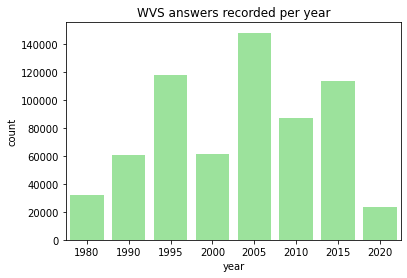

In [25]:
ax = sns.countplot(x=df.year,color="lightgreen")
ax.set_title("WVS answers recorded per year");

Since the country codes are saved in a separate tab-separated-values file,
we will have to read them into our dataframe as well.

In [13]:
iso_codes = pd.read_csv("data/VWS/iso country codes/iso3166.tsv", sep="\t")
iso_codes["Numeric"] = iso_codes["Numeric"].fillna(0).astype(int)
alpha2_to_alpha3 = iso_codes.set_index("Alpha-2 code")["Alpha-3 code"].to_dict()

def map_codes(alpha2val):
    if alpha2val in alpha2_to_alpha3:
        return alpha2_to_alpha3[alpha2val]
    else:
        return "invalid"

df["country"] = df["S009"].apply(map_codes)

In [161]:
interesting_questions = ["A001", # family
                         "A002", # friends
                         "A003", # leisure time
                         "A004", # politics
                         "A005", # work
                         "A006", # religion
                         "A010", # happiness
                         "A165", # most people can be trusted
                         "B008", # protecting environment vs econ growth
                         "D059", "D060", # sexism
                         "E069_04", # confidence in press
                         "E069_11", # confidence in government
                         "E069_14", # confidence in environmental protection movement
                         "E235", # importance of democracy
                         "F034", # religious person (maybe redundant with A006)
                         "G006", # proud of nationality
                         ]
# share of non-responses
by_interval = df[interesting_questions].applymap(lambda x: x if x > 0 else np.nan).isna().groupby(df["year"])
non_responses = (by_interval.sum() / by_interval.count().max()).T
non_responses
# most questions have fairly high rates of non-responses in the 1980 interval.
# notable exceptions are A165 (general trust) and F034 (religious person).
# other questions undergo large fluctuations
# Overall, A001-A006, A165, E069_04, F034 and G006 seem like the most reliable values

year,1980,1990,1995,2000,2005,2010,2015,2020
A001,0.200329,0.003055,0.010337,0.009164,0.024444,0.002212,0.001854,0.000418
A002,0.200356,0.003608,0.013270,0.011463,0.026797,0.003554,0.002677,0.000634
A003,0.200525,0.006844,0.019130,0.014700,0.032596,0.006891,0.004599,0.000856
A004,0.200821,0.009076,0.021955,0.019676,0.039319,0.010802,0.008827,0.001591
A005,0.200713,0.005287,0.016999,0.013142,0.035691,0.010169,0.008260,0.001173
A006,0.202777,0.008793,0.023115,0.013291,0.036709,0.008948,0.008065,0.001773
A010,0.137342,0.195198,0.796886,0.416369,1.000000,0.590482,0.766165,0.157605
A165,0.017188,0.021571,0.031261,0.015664,0.058988,0.015907,0.013628,0.001740
B008,0.215932,0.407502,0.351872,0.074760,0.509484,0.043715,0.048044,0.007242
D059,0.215932,0.407502,0.322924,0.052980,0.473132,0.027633,0.024929,0.003790


Since the dataset is very huge with all individual rows for each person asked, we could also
create a yearly average over the whole country. This might give us a better time when working with
the set overall.

In [178]:
wvs_agg = df.groupby(['country','year']).mean()
wvs_agg

studyno     stdyno_w      S001  S002  S002EVS    S002vs  \
country year                                                                
ALB     1995  4001.000000   341.000000  2.000000   3.0      NaN  3.000000   
        2000  4001.000000    12.000000  2.000000   4.0      NaN  4.000000   
        2005  7503.000000  4800.000000  1.000000   NaN      4.0  5.000000   
        2015  7503.000000  7500.000000  1.000000   NaN      5.0  7.000000   
AND     2005  4001.000000     2.000000  2.000000   5.0      NaN  5.000000   
...                   ...          ...       ...   ...      ...       ...   
invalid 1990  7503.000000  4460.000000  1.000000   NaN      2.0  2.000000   
        1995  5632.493128  1957.585139  1.534125   3.0      3.0  3.465875   
        2000  4001.000000    12.000000  2.000000   4.0      NaN  4.000000   
        2005  6802.330771  3840.031136  1.200077   5.0      4.0  5.000000   
        2015  7503.000000  7500.000000  1.000000   NaN      5.0  7.000000   

                    S003     COW_NUM  S004           S006  ...     Y022B  \
country year                                               ...             
ALB     1995    8.000000  339.000000   1.0     500.000000  ...  0.433755   
        2000    8.000000  339.000000   NaN     500.500000  ...  0.486757   
        2005    8.000000  339.000000   NaN     777.335072  ... -3.000000   
        2015    8.000000  339.000000   NaN     718.000000  ... -3.000000   
AND     2005   20.000000  232.000000   NaN     502.000000  ...  0.710509   
...                  ...         ...   ...            ...  ...       ...   
invalid 1990  840.111857  201.170022   NaN    1976.087808  ... -3.000000   
        1995  855.396692  173.025856   1.0     540.291405  ... -1.744083   
        2000  862.000000  101.000000   NaN     600.500000  ...  0.585211   
        2005  800.916202  260.428214   NaN    9115.974438  ... -2.331008   
        2015  826.000000  201.000000   NaN  125034.404922  ... -3.000000   

                 Y022C      Y023     Y023A     Y023B     Y023C      Y024  \
country year                                                               
ALB     1995  0.678069  0.393257  0.087212  0.526822  0.541812  0.157590   
        2000  0.730147  0.250939  0.053403  0.319702  0.374490  0.202671   
        2005 -3.000000 -3.000000 -3.000000 -3.000000 -3.000000 -3.000000   
        2015 -3.000000 -3.000000 -3.000000 -3.000000 -3.000000 -3.000000   
AND     2005  0.777277  0.776402  0.804663  0.669453  0.858829  0.634568   
...                ...       ...       ...       ...       ...       ...   
invalid 1990 -3.000000 -3.000000 -3.000000 -3.000000 -3.000000 -3.000000   
        1995 -1.684813 -1.217660 -1.276685 -1.259723 -1.148464 -1.161639   
        2000  0.814630  0.229982  0.159611  0.110368  0.418925  0.424008   
        2005 -2.269865 -2.327259 -2.359250 -2.347785 -2.307480 -2.294079   
        2015 -3.000000 -3.000000 -3.000000 -3.000000 -3.000000 -3.000000   

                 Y024A     Y024B     Y024C  
country year                                
ALB     1995  0.193913  0.118661  0.157526  
        2000  0.253375  0.132402  0.192173  
        2005 -3.000000 -3.000000 -3.000000  
        2015 -3.000000 -3.000000 -3.000000  
AND     2005  0.526030  0.747725  0.638171  
...                ...       ...       ...  
invalid 1990 -3.000000 -3.000000 -3.000000  
        1995 -1.159444 -1.744762 -1.759936  
        2000  0.427305  0.421097  0.424283  
        2005 -2.304181 -2.315769 -2.326812  
        2015 -3.000000 -3.000000 -3.000000  

[392 rows x 824 columns]

# Exploration

# TODO: Adapt this text

Since we know from other datasets that countries like Germany refuse to use Nuclear Energy to greater extent,
while their neighbours like France are one of the top consumers of nuclear energy, it would
be interesting what characterises such country.

## Economic Growth versus Protecting the Environment



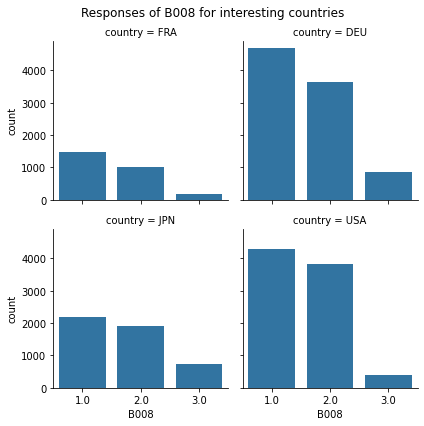

In [26]:
comp_countries = ['JPN','DEU','USA','FRA']
nuc_comp = df.loc[df.country.isin(comp_countries)]
g = sns.FacetGrid(nuc_comp, col="country", col_wrap=2)
g.map_dataframe(sns.countplot, x="B008");
g.fig.subplots_adjust(top=0.9);
g.fig.suptitle('Responses of B008 for interesting countries');

We can see, that for Germany the disparity between category '1' (Protecting the Environment) versus category '2' (Economic growth and protecting the enviroment), is larger than for the other countries.
This may mean that Germany puts more focus on Protecting the Environment.

There are certain Movements like 'Atomkraft:Nein' that were/are very prominent in german speaking countries. This may have an effect on this orientation. 

To further analyse this, we could also look at the values over time to get insight when/if something changes at some point.

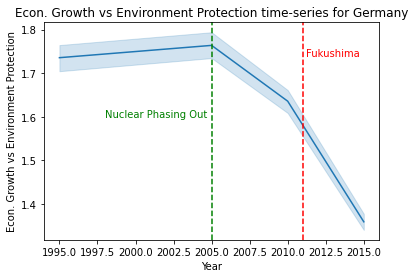

In [17]:
ax = sns.lineplot(x=nuc_comp.year, y=nuc_comp.loc[nuc_comp.country == 'DEU','B008'])

plt.axvline(x=2011, label="Fukushima Disaster", color="red", linestyle="--")
plt.text(2011.2, 1.74,'Fukushima',c="red")

plt.axvline(x=2005, label="Nuclear Phasing Out", color="green", linestyle="--")
plt.text(1998, 1.6,'Nuclear Phasing Out',c="green")

ax.set_title("Econ. Growth vs Environment Protection time-series for Germany")
ax.set_ylabel("Econ. Growth vs Environment Protection")
ax.set_xlabel("Year");

We can see a pretty clear trend down towards 'Protecting environment'.
Interestingly, this change starts at around 2005. If we research the year 2005, this is the start of the 'phasing-out' phase for nuclear energy. 

This was initiated by the German Green Party, which is heavily anti-nuclear energy. For reference, see this BBC article from back then: http://news.bbc.co.uk/1/hi/world/europe/4295389.stm

For even better understanding if other countries also had such a moment of 'phasing out', we should look at other countries too that use nuclear energy heavily.

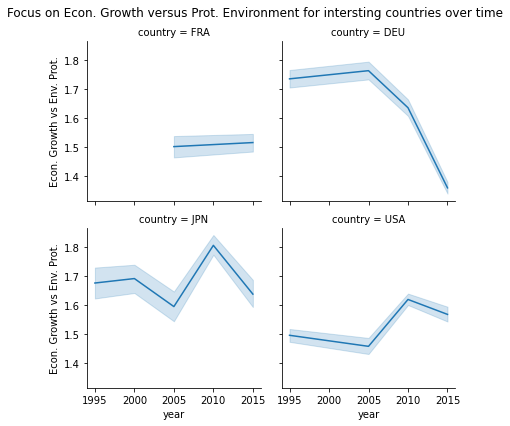

In [28]:
g = sns.FacetGrid(nuc_comp, col="country", col_wrap=2)
g.map_dataframe(sns.lineplot, x="year", y="B008")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Focus on Econ. Growth versus Prot. Environment for intersting countries over time')
g.set_ylabels("Econ. Growth vs Env. Prot.");

We can see that the other countries we looked at don't experience a significant drop like Germany did.
For Japan, we can see that after Fukushima occurred, the focused shifted backed to earlier levels.
The trend still remains upward in general for countries that rely on nuclear energy.

# Combining with Our World in Data Energy Dataset

## Preprocessing and Merging with WVS

### OWID Energy
As a first step we will pull out all features that are relevant for
nuclear power related to countries. These include the following:

In [149]:
nuclear_vars = [
                'nuclear_share_elec',
                'nuclear_cons_change_pct', 
                'nuclear_share_energy',
                'nuclear_cons_change_twh',
                'nuclear_consumption',
                'nuclear_elec_per_capita',
                'nuclear_energy_per_capita',
                'nuclear_electricity',
                'primary_energy_consumption',
                'country',
                'year', 
                'iso_code'
]
owid_nuc = owid.loc[:, owid.columns.isin(nuclear_vars)]
owid_nuc = owid_nuc.set_index('country')
owid_nuc['nuclear_comp_share_percent'] = owid_nuc["nuclear_consumption"] / owid_nuc["primary_energy_consumption"] * 100

There seem to be quite a few NAs in the selected data.
We should figure out a way to sensibly remove/replace them or find out where they come from. 

We can find explanations for the missing data on the OWID website. They conclude that most of the missing data is either locked or non-public (I would guess the OPEC, e.g. Oil orginaisation containing the Arab Emirates, Afghanistan etc.). THey also mention lower-income countries mostly do not report their data, or the data is in bad shape (due to lacking resources in this regard would be a guess). For a more detailed report please refer to https://ourworldindata.org/energy-missing-data

We also see this confirmed if we actually look at the grouped means of average
missing values per country below:

In [150]:
missing_nuc_data = owid_nuc.isna().groupby('country').sum().mean(axis=1).sort_values(ascending=False)
missing_nuc_data.head(10)

country
Yugoslavia        106.250000
Czechoslovakia    106.166667
OPEC              104.166667
Middle East        99.583333
Myanmar            96.916667
Eswatini           94.416667
Cote d'Ivoire      94.416667
Bolivia            92.500000
Mongolia           92.500000
Nigeria            92.500000
dtype: float64

Before merging with the WVS, we should also take a look to see
if the years, as we are going to have to aggregate them for the
OWID set (since WVS only has time instances every 5 years).

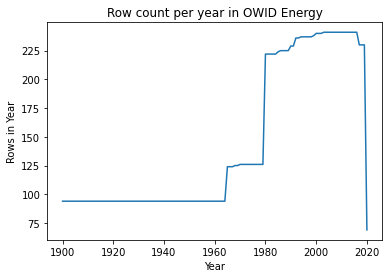

In [151]:
owid_years_counts = owid_nuc.year.value_counts().sort_index()
ax = sns.lineplot(y=owid_nuc.year.value_counts().sort_index(), x=owid_years_counts.index)
ax.set_title("Row count per year in OWID Energy")
ax.set_xlabel("Year")
ax.set_ylabel("Rows in Year");

We can see OWID Energy has data for every year, with more
rows being available after around 1980. Since the WVS's recordings
starts only in 1980, we won't really need the data before that
point in time.

In [152]:
owid_cut = owid_nuc.loc[owid_nuc.year >= 1980, :]

In order to match the WVS's format, we will also proceed and average
the values of OWID Energy over a time horizon of 5 years, starting with 1980.
For this, we group by country and add a rolling average over 5 years for all countries.
We then take only those year averages out that are in the range of the WVS's years, then
add some new indices and suffixes for the columns.

In [153]:
valid_years = df.year.unique()
owid_agg = owid_cut.groupby('iso_code').rolling(5, min_periods=1).mean()
owid_agg = owid_agg.loc[owid_agg.year.isin(valid_years), :]
owid_agg = owid_agg.set_index('year', append=True).add_suffix("_avg")
owid_agg

nuclear_electricity_avg  nuclear_share_elec_avg  \
iso_code country  year                                                      
ABW      Aruba    1990.0                      NaN                     NaN   
                  1995.0                      NaN                     NaN   
                  2000.0                      0.0            0.000000e+00   
                  2005.0                      0.0            0.000000e+00   
                  2010.0                      0.0            0.000000e+00   
...                                           ...                     ...   
ZWE      Zimbabwe 1995.0                      NaN                     NaN   
                  2000.0                      0.0            2.960595e-16   
                  2005.0                      0.0            1.776357e-16   
                  2010.0                      0.0            1.776357e-16   
                  2015.0                      0.0            1.776357e-16   

                          nuclear_cons_change_pct_avg  \
iso_code country  year                                  
ABW      Aruba    1990.0                          NaN   
                  1995.0                          NaN   
                  2000.0                          NaN   
                  2005.0                          NaN   
                  2010.0                          NaN   
...                                               ...   
ZWE      Zimbabwe 1995.0                          NaN   
                  2000.0                          NaN   
                  2005.0                          NaN   
                  2010.0                          NaN   
                  2015.0                          NaN   

                          nuclear_share_energy_avg  \
iso_code country  year                               
ABW      Aruba    1990.0                       NaN   
                  1995.0                       NaN   
                  2000.0                       NaN   
                  2005.0                       NaN   
                  2010.0                       NaN   
...                                            ...   
ZWE      Zimbabwe 1995.0                       NaN   
                  2000.0                       NaN   
                  2005.0                       NaN   
                  2010.0                       NaN   
                  2015.0                       NaN   

                          nuclear_cons_change_twh_avg  \
iso_code country  year                                  
ABW      Aruba    1990.0                          NaN   
                  1995.0                          NaN   
                  2000.0                          NaN   
                  2005.0                          NaN   
                  2010.0                          NaN   
...                                               ...   
ZWE      Zimbabwe 1995.0                          NaN   
                  2000.0                          NaN   
                  2005.0                          NaN   
                  2010.0                          NaN   
                  2015.0                          NaN   

                          nuclear_consumption_avg  \
iso_code country  year                              
ABW      Aruba    1990.0                      NaN   
                  1995.0                      NaN   
                  2000.0                      NaN   
                  2005.0                      NaN   
                  2010.0                      NaN   
...                                           ...   
ZWE      Zimbabwe 1995.0                      NaN   
                  2000.0                      NaN   
                  2005.0                      NaN   
                  2010.0                      NaN   
                  2015.0                      NaN   

                          nuclear_elec_per_capita_avg  \
iso_code country  year                                  
ABW      Aruba    1990.0         

### Merging OWID and WVS

As the WVS survey is really large, we will probably have to find a way for future
usage to limit the size of each function call. In memory, the WVS survey is around
~4GB in size. We will therefore define a function that allows the merger of the OWID
nuclear subset and a feature subset of the WVS:

In [182]:
def merge_for_featureset(subset):
  df_subset = wvs_agg.loc[:, wvs_agg.columns.isin(subset + ['country','year'])]
  merged_df = pd.merge(owid_agg.reset_index(), df_subset.reset_index(), left_on=['iso_code','year'], right_on=['country','year'])
  merged_df = merged_df.rename(columns={"country_x":"country"})
  merged_df = merged_df.set_index(['iso_code','country','year'])
  return merged_df

nuc_and_char = merge_for_featureset(interesting_questions)
nuc_and_char

nuclear_electricity_avg  nuclear_share_elec_avg  \
iso_code country      year                                                      
ALB      Albania      1995.0                      NaN                     NaN   
                      2000.0                   0.0000            0.000000e+00   
                      2005.0                   0.0000            0.000000e+00   
                      2015.0                   0.0000            0.000000e+00   
ARG      Argentina    1980.0                      NaN                     NaN   
...                                               ...                     ...   
ZAF      South Africa 2005.0                  12.3712            5.351600e+00   
                      2010.0                  12.5118            5.208000e+00   
ZMB      Zambia       2005.0                   0.0000            1.776357e-16   
ZWE      Zimbabwe     2000.0                   0.0000            2.960595e-16   
                      2010.0                   0.0000            1.776357e-16   

                              nuclear_cons_change_pct_avg  \
iso_code country      year                                  
ALB      Albania      1995.0                          NaN   
                      2000.0                          NaN   
                      2005.0                          NaN   
                      2015.0                          NaN   
ARG      Argentina    1980.0                     -13.0760   
...                                                   ...   
ZAF      South Africa 2005.0                      -1.1692   
                      2010.0                       2.3482   
ZMB      Zambia       2005.0                          NaN   
ZWE      Zimbabwe     2000.0                          NaN   
                      2010.0                          NaN   

                              nuclear_share_energy_avg  \
iso_code country      year                               
ALB      Albania      1995.0                       NaN   
                      2000.0                       NaN   
                      2005.0                       NaN   
                      2015.0                       NaN   
ARG      Argentina    1980.0                    1.4120   
...                                                ...   
ZAF      South Africa 2005.0                    2.3914   
                      2010.0                    2.3428   
ZMB      Zambia       2005.0                       NaN   
ZWE      Zimbabwe     2000.0                       NaN   
                      2010.0                       NaN   

                              nuclear_cons_change_twh_avg  \
iso_code country      year                                  
ALB      Albania      1995.0                          NaN   
                      2000.0                          NaN   
                      2005.0                          NaN   
                      2015.0                          NaN   
ARG      Argentina    1980.0                      -0.9780   
...                                                   ...   
ZAF      South Africa 2005.0                      -0.5636   
                      2010.0                       0.6682   
ZMB      Zambia       2005.0                          NaN   
ZWE      Zimbabwe     2000.0                          NaN   
                      2010.0                          NaN   

                              nuclear_consumption_avg  \
iso_code country      year                              
ALB      Albania      1995.0                      NaN   
                      2000.0                      NaN   
                      2005.0                      NaN   
                      2015.0                      NaN   
ARG      Argentina    1980.0                   6.5000   
...                                               ...   
ZAF      South Africa 2005.0                  31.5830   
                      2010.0                  34.0058   
ZMB      Zambia       2005.0                      NaN   
ZWE   

We could now try to find correlations between the nuclear energy and the country characteristics of the world value survey. As a simple first step, we could look a the heatmap of the correlations:

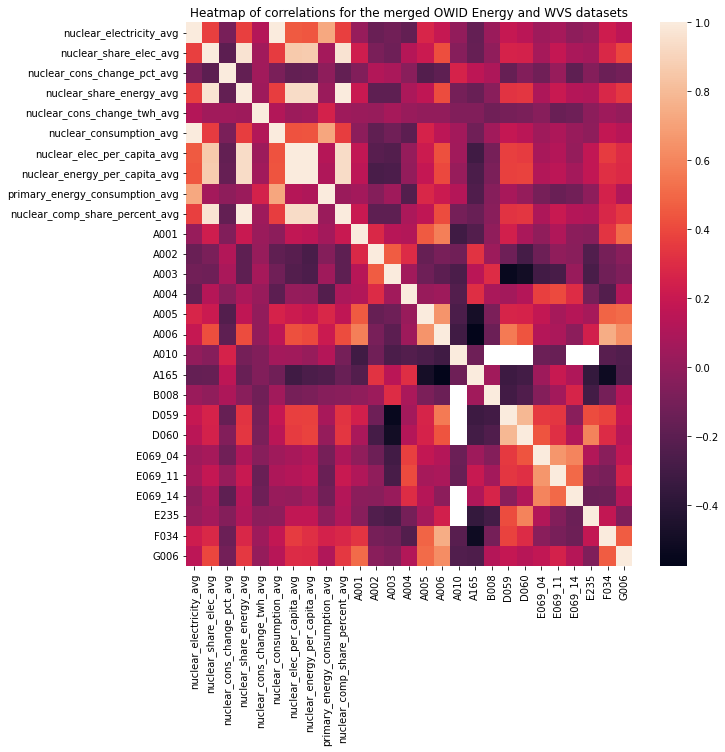

In [183]:
plt.figure(figsize=(10,10));
ax = sns.heatmap(nuc_and_char.corr())
ax.set_title("Heatmap of correlations for the merged OWID Energy and WVS datasets");

Sadly, from this we can not see very much, at least for these chosen characteristics. Perhaps one would be able to see something if we were to use
more of the country characteristics.

As a next step, we could do just this: Select more subsets of features (characteristics for the country), merge them again and create sub-plots for each. The meanings of the labels starting with A,B,... are documented in the World Values Survey's Report Document. 

## Correlations
### Correlation with Environment Features

In [67]:
def create_merged_feature_subset(feature_letter):
  characteristics = [col for col in df if col.startswith(feature_letter)]
  owid_merged_characteristics = merge_for_featureset(characteristics)
  corrs = owid_merged_characteristics.corr()
  return owid_merged_characteristics, corrs

def evaluate_correlation_matrix(corr_matrix):
  filtered_corrs = corr_matrix.loc[corr_matrix.index.str.startswith('nuclear'), 
                                                  ~corr_matrix.columns.str.startswith('nuclear')]
  is_subset_significant = np.abs(filtered_corrs) >= 0.7
  characteristics_significant_count = is_subset_significant.sum().sum()
  print(f"""Amount of significant correlations between WVS characteristics subset \
and nuclear energy features: {characteristics_significant_count}""")  

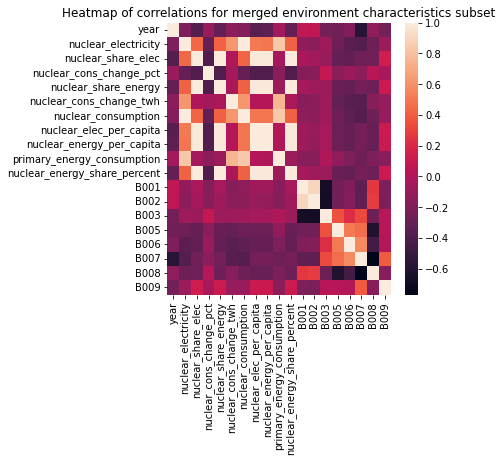

In [68]:
env_merged, env_corr = create_merged_feature_subset('B')
plt.figure(figsize=(5,5));
ax = sns.heatmap(env_corr.corr())
ax.set_title("Heatmap of correlations for merged environment characteristics subset");

Again, we see that none of the environment feature's correlations to the nuclear features are significant. We will therefore continue with the next subset of features.
Before we begin, a logical correlation will be between the primary energy consumption and nuclear energy consumption in percent.
This is because the values are generated from each other (see cells above). We will therefore ignore the correlations in this regard.

### Correlation with Perceptions of Life Features

Since this feature set is quite large, the ticks in the heatmap won't really
be readable anymore (118 features).

In [69]:
merged_perception, perception_corr = create_merged_feature_subset('A')

To reduce the visual impact and to improve readability, we filter out any correlation scores over a threshold of 0.7. Values higher than this could be considered highly significant and could be analysed further. We also only filter out the correlations relating the nuclear features to all other features.

In [70]:
evaluate_correlation_matrix(perception_corr)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 2


### Correlation with Work

For work, we will repeat the steps above, like for the perceptions of life features.

In [71]:
merged_work, works_corrs = create_merged_feature_subset('C')

In [72]:
evaluate_correlation_matrix(works_corrs)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 2


### Correlation with Family

In [73]:
merged_family, family_corrs = create_merged_feature_subset('D')

In [74]:
evaluate_correlation_matrix(family_corrs)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 2


### Correlation with Politics and Society

It's pretty weird that we see no correlations here, as E105 is a feature that describes Anti-Nuclear energy movements. One would assume that such feature would correlate with less nuclear energy use/creation in a country.

In [75]:
merged_politics, politics_corrs = create_merged_feature_subset('E')

In [76]:
evaluate_correlation_matrix(politics_corrs)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 2


If we look at the documentation for the feature, we notice that it is only recorded for 1990/1985. For this reason, we probably don't get that much data for most countries and over a long time-horizon.

In [77]:
merged_politics.loc[:, ['E105','year']].value_counts()

E105  year
1.0   1990    20788
2.0   1990    17585
3.0   1990     7582
4.0   1990     3480
1.0   1985     1001
2.0   1985      627
3.0   1985      349
4.0   1985      294
dtype: int64

### Correlation with Religion and Morale

In [78]:
merged_religion, religion_corrs = create_merged_feature_subset('F')

In [79]:
evaluate_correlation_matrix(religion_corrs)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 2


### Correlation with National Identity

In [80]:
merged_national, national_corrs = create_merged_feature_subset('G')

In [81]:
evaluate_correlation_matrix(national_corrs)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 9


This is interesting, for the National Identity feature-subset there seem to be
6 features that correlate significantly with some of the nuclear features from OWID. To further analyse them, we will look at all the variables that are in fact significant:

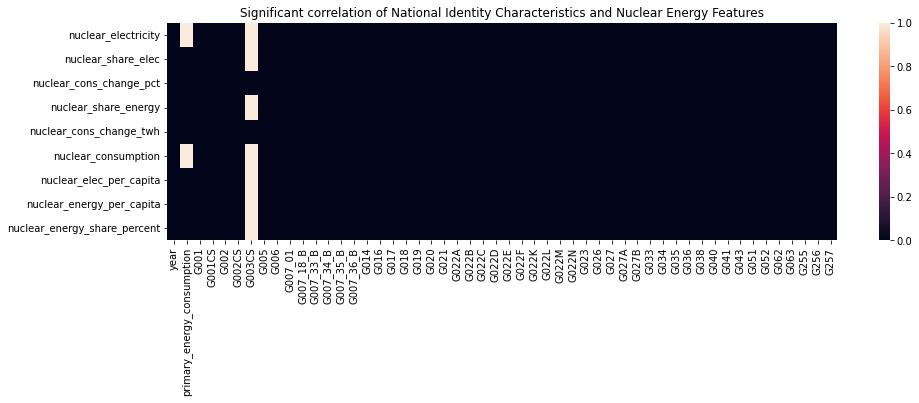

In [82]:
nat_filtered = national_corrs.loc[national_corrs.index.str.startswith('nuclear'), 
                                                  ~national_corrs.columns.str.startswith('nuclear')]
plt.figure(figsize=(15,4));
ax = sns.heatmap(np.abs(nat_filtered) >= 0.7)
ax.set_title("Significant correlation of National Identity Characteristics and Nuclear Energy Features");

We can see the releveant feature is G003CS. If we look at the documentation of the WVS (World Value Survey) the value is not really found there. From the descriptions of G001CS and G002CS, we can gather that this field likely describes the "geographical group you belong to in third place". An example could be I'm from Vienna first, Austria second and Europe third.

This doesn't really give us a lot of information, but we still should look further into this variable to understand why it correlates:

In [83]:
g003cs = merged_national.loc[:,'G003CS']
g003cs.value_counts()

356005.0    1641
484005.0    1062
152005.0    1026
156001.0     928
356001.0     740
724003.0     639
566004.0     499
724005.0     261
724002.0     250
152001.0     238
484001.0     198
566003.0     194
724004.0     193
484002.0     173
566002.0     165
152004.0     124
724001.0      99
566001.0      94
152003.0      89
484004.0      65
356002.0      64
156006.0      51
356003.0      43
152002.0      23
484003.0      19
356004.0      12
156003.0      10
156004.0       8
156005.0       3
Name: G003CS, dtype: int64

Since we don't get documentation for this field (Which is very weird), we can not assume anything for the correlation to the nuclear vars.

What can be observed is, that if we change the threshold for significant correlation to >= 0.6, we also get the variables G001CS and G002CS as significant. But, since we set to tests this on 0.7, this would be 'cheating'.

### Correlation with Security

In [84]:
merged_security, security_corrs = create_merged_feature_subset('H')

In [85]:
evaluate_correlation_matrix(security_corrs)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 2


### Correlation with Admin and protocol variables

In [86]:
merged_admin, admin_corrs = create_merged_feature_subset('S')

In [87]:
evaluate_correlation_matrix(admin_corrs)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 2


### Correlation with Respondents' parents (EVS)

In [88]:
merged_parent, parent_corrs = create_merged_feature_subset('V')

In [89]:
evaluate_correlation_matrix(parent_corrs)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 2


### Correlation with Presondent's partner (EVS)


In [90]:
merged_partner, partner_corrs = create_merged_feature_subset('W')

In [91]:
evaluate_correlation_matrix(partner_corrs)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 2


### Correlation with Socio Demographics

In [92]:
merged_sozio, sozio_corrs = create_merged_feature_subset('X')

In [93]:
evaluate_correlation_matrix(sozio_corrs)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 2


### Correlation with special indexes

In [94]:
merged_special, special_corrs = create_merged_feature_subset('X')

In [95]:
evaluate_correlation_matrix(special_corrs)

Amount of significant correlations between WVS characteristics subset and nuclear energy features: 2


## Testing using ML and feature selection

Since we found no significant direct correlation between any of the characteristics of the world value survey (1981-2021), another idea would be to try to predict some of the nuclear variables using machine learning. There may a not a single characterstic that is good enough to 'predict' the nuclear energy features like we tested before, but a combination of multiple.

For this reason we could apply a regression algorithm and feature selection on the merged data to see if any combination of features gives us the ability to predict the nuclear features. 

For sake of simplicity, we are first going to start using linear methods like Lasso or Ridge Regression that do regression with built in feature-selection. To get the benefits of both methods, we are going to use ElasticNet and search for fitting parameters using GridSearch.

In order to keep the country columns in the data, we will have to encode them either via
OneHotEncoding or LabelEncoding. Since we have quite a lot of countries, OneHot may be
an issue since we would have a lot of columns. LabelEncoding on the other hand would impose
a natural order on the in reality unordered countries. We will therefore try OneHot first,
then try LabelEncoding if it does not really work out.

We will also d

In [115]:
relevant_nuclear_features = [
                             'E105', #Aproval of Anti-Nuclear Movement
                             'E069_11', #Confidence in the Government
                             'E069_03', #Confidence Education System
                             'E001', #Aims of country first choice
                             'E022', #Opinion about scientific advances
                             'E016', #Future changes: More emphasis on technology
                             'B008', #Protecting Env. vs Economic Growth
                             'B007', #Protecting Env and fighting pollution is less urgent
                             'B005', #All talk about the environment make people anxious
                             'B003', #Government should reduce environmental pollution
                             'A071B', #Member: Belong to conservation, the environment, ecology
                             ]

nuc_intersting_merge = pd.get_dummies(merge_for_featureset(relevant_nuclear_features))

Sadly, we also get quite a large amount of NAs for the data. This is because some of the chosen columns are
only reported for certain year ranges (ae. A071B only for 1990, B005 also only for 1990).
It would therefore be a bad idea to remove all rows that have any NAs, as it would probably drop ~88% of the data out.
We could therefore either try to get a model for only a timeframe where we have enough data, or interpolate/replace
the NaNs with a code for unknown. A problem with the interpolation approach (and a model generated from this
in general), would be that we can't really generate data for 2021/2022 from 30 year old data only.

A simple first try would be to use the special value -5 also used in the dataset for 'missing' and see if the model
is able to work with that. We below see that for some features there are lots of missing data:

In [108]:
nuc_intersting_merge.isnull().sum() * 100 / len(df)

year                        0.000000
nuclear_electricity         6.959174
nuclear_share_elec          7.967777
nuclear_cons_change_pct    54.432475
nuclear_share_energy       17.579725
                             ...    
iso_code_VNM                0.000000
iso_code_YEM                0.000000
iso_code_ZAF                0.000000
iso_code_ZMB                0.000000
iso_code_ZWE                0.000000
Length: 128, dtype: float64

### Model with country codes included

In [159]:
nuc_intersting_merge = nuc_intersting_merge.fillna(-5)

target = nuc_intersting_merge.loc[:, 'nuclear_comp_share_percent']
features = nuc_intersting_merge.drop('nuclear_comp_share_percent', axis=1)
features = features.loc[:,~features.columns.str.startswith('nuclear')]
features = features.drop('primary_energy_consumption', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target)

regressor = ElasticNetCV(cv=5, random_state=0)
regressor.fit(X_train, y_train)

ElasticNetCV(cv=5, random_state=0)

RMSE: 24.610644272139425


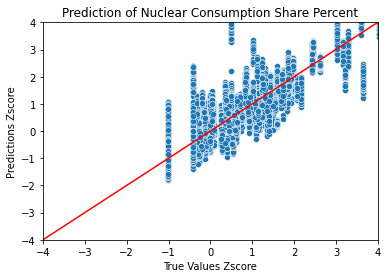

In [258]:
def evaluate_model(model, xtest, ytest):
    predictions = model.predict(xtest)
    ax = sns.scatterplot(x=(ytest - ytest.mean())/ ytest.std(), y=(predictions - predictions.mean())/ predictions.std())
    ax.axline((0,0),(1,1),c="red")
    ax.set_title("Prediction of Nuclear Consumption Share Percent")
    ax.set_xlabel("True Values Zscore")
    ax.set_ylabel("Predictions Zscore")
    ax.set(xlim=(-4,4))
    ax.set(ylim=(-4,4))
    print(f"RMSE: {mean_squared_error(y_test, predictions)}")

evaluate_model(regressor, X_test, y_test)

The predictions don't seem very good. Most of them are on
show systematic differences from the optimal line between
predictions and true values. We see quite a few outliers everywhere.

We could now also look at which variables were selected by ElasticNet:

In [222]:
def get_sorted_coefficients(model, trainingset, n=10):
    coefs = pd.Series(model.coef_)
    coefs.index = trainingset.columns
    print(coefs.abs().sort_values(ascending=False).head(n))

get_sorted_coefficients(regressor, X_train)

iso_code_FRA    16.359725
iso_code_SWE    12.819724
iso_code_LTU     8.821821
iso_code_CHE     8.269502
iso_code_SVN     7.912902
iso_code_BGR     7.268527
iso_code_SVK     6.744330
iso_code_FIN     6.357111
iso_code_BEL     5.802619
iso_code_KOR     5.036011
dtype: float64


We can quickly see that most of the features with high coefficients are the country features.
For the thing we are trying to predict (can characteristics of a country predict the nuclear energy
comp share), we have to ask ourselves if it even makes sense to include them.

To test if the model would still be able to predict using only characteristics, we should exclude the
country codes and run the model training again:

In [170]:
features_country_omitted = features.loc[:,~features.columns.str.startswith("iso")]

X_train_com, X_test_com, y_train_com, y_test_com = train_test_split(features_country_omitted, target)

regressor_com = ElasticNetCV(cv=5, random_state=0)
regressor_com.fit(X_train_com, y_train_com)

ElasticNetCV(cv=5, random_state=0)

In [223]:
get_sorted_coefficients(regressor_com, X_train_com)

A071B      0.798228
E069_03    0.470628
B007       0.303897
E001       0.226633
B003       0.194081
E016       0.173137
B005       0.152277
E022       0.116413
year       0.114719
B008       0.069866
dtype: float64


### Model after removing country codes from features

RMSE: 73.94968794157121


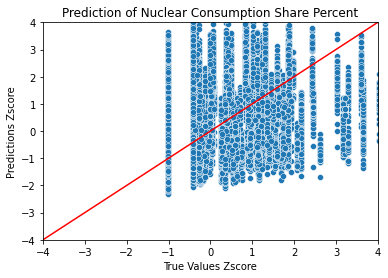

In [259]:
evaluate_model(regressor_com, X_test_com, y_test_com)

After removing the country codes, we don't have any prediction power anymore.
We can only really see noise being predicted by the model.

Our issue with the model is probably due to most of the data just being the missing
value -5. We will have to find a way to either limit our scope to years with
enough data available, or find features from the WVS or another dataset that offer more
information.

We could try a more complex model, although this would not solve the issue of
having lots and lots of missing data in the first place.

## Testing with whole characteristics set.

In [190]:
merged = pd.merge(owid_nuc, df, how='inner', left_on=['iso_code','year'],
                        right_on=['country','year']).drop('country', axis=1)

In [253]:
merged = merged.fillna(-5)

full_target = merged.loc[:, 'nuclear_comp_share_percent']
full_features = merged.drop(columns=['nuclear_comp_share_percent','iso_code'], axis=1)
full_features = full_features.loc[:,~full_features.columns.str.startswith('nuclear')]
full_features = full_features.drop('primary_energy_consumption', axis=1)
full_features = full_features.select_dtypes(exclude="object")

In [255]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(full_features, full_target)

reg_full = ElasticNetCV(cv=5, random_state=0)
reg_full.fit(X_train_full, y_train_full)

ElasticNetCV(cv=5, random_state=0)

RMSE: 69.79958378662343


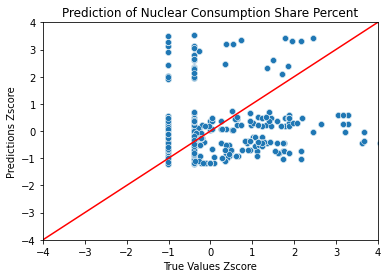

In [260]:
evaluate_model(reg_full, X_test_full, y_test_full)

In [268]:
get_sorted_coefficients(reg_full, X_train_full,5)

S021    2.220055e-11
S007    1.727768e-12
year    0.000000e+00
F059    0.000000e+00
F047    0.000000e+00
dtype: float64


We can see that the full model removes all features expect for 2, which are also very close to zero.
Therefore, the model just consist of the intercept term and two very small features, which does not
really say anything about the data.

So, as expected, using all features did not solve the issue, since we still have massive amounts of
not recorded (e.g. "missing") data from the WVS. For this reason, we will have to try another approach
and maybe focus on a smaller timeframe were we have data or look for another dataset.